In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import datetime

import matplotlib.pyplot as plt

from scipy import stats
import math
import random

from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score
from sklearn.metrics import  mean_squared_log_error

from xgboost import XGBRegressor

In [20]:
train_File = 'train.csv'
test_File = 'test.csv'

df_train = pd.read_csv(train_File)
df_test = pd.read_csv(test_File)
df_test['SalePrice'] = 0
df_concat = pd.concat([df_train,df_test])

In [3]:
def giveMeWrangledData(df, testFile=False, log=False):
    
    
    df = df.drop(['Id', 'GarageYrBlt','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF'],axis=1)
    
    df['LotFrontage'] =df.LotFrontage.fillna(df.LotFrontage.mode()[0])
    df['MasVnrArea']=df.MasVnrArea.fillna(0.0)
    df['TotalBsmtSF'] = df.TotalBsmtSF.fillna(0)
    df['BsmtFullBath'] = df.BsmtFullBath.fillna(0)
    df['BsmtHalfBath'] = df.BsmtHalfBath.fillna(0)
    df['GarageCars'] = df.GarageCars.fillna(0)
    df['GarageArea'] = df.GarageArea.fillna(0)
    
    #convert data type
    #we are being little lineant to give int64 for YearBuilt, YrSold but those guys are going to be box-coxed 
    #so let them at least enjoy the bigger size for now
    int64_variables = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', \
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', \
                     'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',\
                     'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', \
                     'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']
    
    #if testFile:
    #    int64_variables.remove('SalePrice')

        
        
        
    
    for c in int64_variables:
        if log:
            print("Changing the data type for :", c)
        #df[c] = df[c].astype(np.int64)
        df[c] = df[c].astype(np.float64)
        
    int_to_categorical_variables = ['MSSubClass', 'OverallQual', 'OverallCond', 'FireplaceQu', 'MoSold']
    for c in int_to_categorical_variables:
        df[c] = df[c].astype(str)
        
    df = df.fillna('NotAvailable')
    return df
df = giveMeWrangledData(df_concat)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450.0,Pave,NotAvailable,Reg,Lvl,AllPub,Inside,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,2,2008.0,WD,Normal,208500.0
1,20,RL,80.0,9600.0,Pave,NotAvailable,Reg,Lvl,AllPub,FR2,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,5,2007.0,WD,Normal,181500.0
2,60,RL,68.0,11250.0,Pave,NotAvailable,IR1,Lvl,AllPub,Inside,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,9,2008.0,WD,Normal,223500.0
3,70,RL,60.0,9550.0,Pave,NotAvailable,IR1,Lvl,AllPub,Corner,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,2,2006.0,WD,Abnorml,140000.0
4,60,RL,84.0,14260.0,Pave,NotAvailable,IR1,Lvl,AllPub,FR2,...,0.0,NotAvailable,NotAvailable,NotAvailable,0.0,12,2008.0,WD,Normal,250000.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 76 columns):
MSSubClass       2919 non-null object
MSZoning         2919 non-null object
LotFrontage      2919 non-null float64
LotArea          2919 non-null float64
Street           2919 non-null object
Alley            2919 non-null object
LotShape         2919 non-null object
LandContour      2919 non-null object
Utilities        2919 non-null object
LotConfig        2919 non-null object
LandSlope        2919 non-null object
Neighborhood     2919 non-null object
Condition1       2919 non-null object
Condition2       2919 non-null object
BldgType         2919 non-null object
HouseStyle       2919 non-null object
OverallQual      2919 non-null object
OverallCond      2919 non-null object
YearBuilt        2919 non-null float64
YearRemodAdd     2919 non-null float64
RoofStyle        2919 non-null object
RoofMatl         2919 non-null object
Exterior1st      2919 non-null object
Exterior2nd    

In [5]:
def preProcessData(df, log=False):
    
    print("Shape of the data set before pre processing : ", df.shape )

    
    #get dummies
    if log:
        print("Categorical columns : ", list(df.select_dtypes(exclude=np.number)))
    df = pd.get_dummies(df, dtype=np.float64)
    #df = df.drop(categorical_columns, axis=1)
    
    print("\n\nShape of the data set after pre processing : ", df.shape )
    
    if log:
        print("Columns in the data set are : ",list(df))

    return df
df_prep = preProcessData(df)
df_prep.info()

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Columns: 351 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(351)
memory usage: 7.8 MB


https://stats.stackexchange.com/questions/130262/why-not-log-transform-all-variables-that-are-not-of-main-interest

In [6]:
def newBoxCoxTranformation(df,target,testFile=False, log=False):
    
    #assuming that only numerical features are presented
    print("Shape of the dataset initial : ", df.shape)
    
    if not testFile:
        df =df[df.SalePrice >0]
        print("Shape of the dataset before transformation : ", df.shape)
        y = np.array(df[target].apply( lambda x: math.log(x)))
        X= df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        X = pd.DataFrame(X, columns=x_columns)
        
        #print( X.MSZoning_RH.unique())
        import time
        
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]

            
            '''if c in ['Utilities_AllPub','MSSubClass_150',]:
               
            elif c == 'MSZoning_RH':
                continue
            elif c in ['MSZoning_RL','MSZoning_RM','Street_Grvl'] :
                print("Going for the x+.01")
                #lmax = stats.boxcox_normmax(X[c], brack=(-1.9, 2.1),  method='mle')
                #serie_bc = stats.boxcox(X[c], lmax)
                #print(serie_bc)
                
                #X[c] = X[c].apply(lambda x : math.l(x ))
                
                X[c] = X[c].apply(lambda x : math.tanh(x ))
            else:
                X[c] = stats.boxcox(X[c])[0]
            time.sleep(.1)'''
        
        #X = preprocessing.power_transform( X, method='box-cox')
        
        
        #print("X.MSZoning_RH.unique() : ",X.MSZoning_RH.unique())
        
        #X = pd.DataFrame(X,columns=x_columns)
        
        X = X.values
        print("Shape of the dataset after transformation : ", X.shape, y.shape)
        return X,y
    else:
        df = df[df.SalePrice == 0.0]
        print("Shape of the dataset before transformation : ", df.shape)
        X=df.drop(target,axis = 1)
        x_columns = list(X)
        X = preprocessing.MinMaxScaler(feature_range=(1, 2)).fit_transform(X)
        
        X = pd.DataFrame(X, columns=x_columns)
        for c in list(X):
            if len(X[c].unique()) in  [1,2]:
                if log:
                    print("Skipping Transformation for ", c, "because unique values are :",X[c].unique())
            else:
                if log:
                    print("Boxcoxing : ", c)
                X[c] = stats.boxcox(X[c])[0]
        
        
        #X = preprocessing.power_transform( X, method='box-cox')
        X = X.values
        print("Shape of the dataset after transformation : ", X.shape)
        return X
        
    

X = newBoxCoxTranformation(df_prep,'SalePrice',True,False)  
X,y = newBoxCoxTranformation(df_prep,'SalePrice',False,False)

Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.5, random_state=random.randint(1,500))#, stratify=df.BldgType)

In [8]:
reg = XGBRegressor()
reg.fit(X_train,y_train)
reg.score(X_test,y_test)

0.8546477364562884

In [9]:
np.sqrt(mean_squared_log_error(y_test, reg.predict(X_test)))

0.01114592296002113

In [10]:
reg.fit(X,y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [11]:
reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

##### We need to have different pre-processing logic to test data. We will come back to it little later.

In [12]:
def checkTheTestFile(reg):
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0.0
    
    df_train =  pd.read_csv(train_File)
    df_concat = pd.concat([df_train,df_test])

    #print(df_test[df_test.TotalBsmtSF.isna()])
    #return
    df = giveMeWrangledData(df_concat,True)
    
    #print(df.info())
    df = preProcessData(df)
    #print(df.info())
    X = newBoxCoxTranformation(df,'SalePrice',True)
    #print(np.sqrt(mean_squared_log_error(y, reg.predict(X))))
    
    df_test['SalePrice'] = np.exp(reg.predict(X))
    
    
    return df_test
df_test = checkTheTestFile(reg)

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)


In [13]:
df_test[['Id','SalePrice']]

,Id,SalePrice
0,1461,125787.546875
1,1462,141982.984375
2,1463,191110.000000
3,1464,200240.312500
4,1465,192861.265625
5,1466,184632.828125
6,1467,169653.500000
7,1468,171752.890625
8,1469,204392.515625
9,1470,138786.703125


In [14]:
df_test[['Id','SalePrice']].to_csv('submission.csv',index=False)

##### I got Kaggle Rank of 2539/4463 with RMSLE =0.14357
##### As on 1/17/2019 : 9:06PM IST
* 0.13501 ==> 2040 
* 0.13252 ==> 1865
* 0.13002 ==> 1704
* 0.12658 ==> 1500
* 0.12351 ==> 1250
* 0.12081 ==> 1000
* 0.11572 ==> 500
* 0.11475 ==> 250
* 0.11310 ==> 100
* 0.10985 ==> 50
* 0.10973 ==> 25
* 0.10845 ==> 10
* 0.08021 ==> 5
* 0.00000 ==> 1

##### Now that I know around what score gets what rank; can we have a function which would what would be testing score ?

##### Logic is to predict first the testing samples. Later use that for training and predict the initial training data set. We would then have actual and predicted SalePrices with which we can calculated the RMSLE.

##### Would this logic work ? let us try for our case now and compare that with Kaggle result....Finger crossed :)

In [17]:
def checkTheTestingScore(df_test, max_depth, n_estimator):
    
    start_time = datetime.datetime.now()
 
    df_train =  pd.read_csv(train_File)
    df_train.SalePrice = 0
    df_concat = pd.concat([df_train,df_test])
    
    X,y = newBoxCoxTranformation(preProcessData((giveMeWrangledData(df_concat))),'SalePrice')
    reg=XGBRegressor(max_depth=max_depth, n_estimator=n_estimator)
    
    cv = ShuffleSplit(n_splits=3, test_size=random.randint(7,9)/10, random_state=random.randint(1,1000))
    #print(datetime.datetime())
    cross_cv = cross_val_score(reg,X,y,cv=cv, scoring='neg_mean_squared_log_error',n_jobs=3)
    print(" Validat Median Score : ", np.sqrt(np.median(cross_cv) * -1), "Average Score : ", np.sqrt(np.average(cross_cv) * -1) )
    
    reg.fit(X,y)
    training_score = np.sqrt(mean_squared_log_error(y, reg.predict(X)))
    print("Training Score :", training_score)
    
    X = newBoxCoxTranformation(preProcessData((giveMeWrangledData(df_concat))),'SalePrice',True)
    df_train =  pd.read_csv(train_File)
    df_train['predicted_SalePrice']=np.exp(reg.predict(X))
    
    testing_score = np.sqrt(mean_squared_log_error(df_train.SalePrice,df_train.predicted_SalePrice))
    
    print("max_depth :", max_depth, "n_estimator :", n_estimator,"RMSLE : ", testing_score)
    print("Total time for validation to testing score : ", datetime.datetime.now()- start_time)
    
    return [training_score, np.sqrt(np.average(cross_cv) * -1), testing_score]
    
dummy = checkTheTestingScore(df_test,3,100)
print(dummy[0],dummy[1],dummy[2],3,100)

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
 Validat Median Score :  0.00604585540551122 Average Score :  0.005923071617358857
Training Score : 0.002591130324273707
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 100 RMSLE :  0.16589711298464754
Total time for validation ot testing score :  0:00:18.156452
0.002591130324273707 0.005923071617358857 0.16589711298464754 3 100


##### This is good news; we have the RMSLE calculation matching amost to that of Kaggle.

In [26]:
def doGridSearch():
    
    start_time = datetime.datetime.now()
    
    df_train = pd.read_csv(train_File)
    df_test = pd.read_csv(test_File)
    df_test['SalePrice'] = 0
    df_concat = pd.concat([df_train,df_test])
    
    df = giveMeWrangledData(df_concat)
    df_prep = preProcessData(df)
    
    X,y = newBoxCoxTranformation(df_prep,'SalePrice',False,False)
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, \
                                                        random_state=random.randint(1,500))#, stratify=df.BldgType)
    
    
    score_list = []
    for i in range(3,5):
        for j in range(100,900,100):
            loop_start = datetime.datetime.now()
            
            reg = XGBRegressor(max_depth=i, n_estimators=j)

            cv = ShuffleSplit(n_splits=3, test_size=random.randint(7,9)/10, random_state=random.randint(1,1000))
            #print(datetime.datetime())
            cross_cv = cross_val_score(reg,X,y,cv=cv, scoring='neg_mean_squared_log_error',n_jobs=3)
            print(" Validat Median Score : ", np.sqrt(np.median(cross_cv) * -1), \
                  "Average Score : ", np.sqrt(np.average(cross_cv) * -1) )

            reg.fit(X,y)
            training_score = np.sqrt(mean_squared_log_error(y, reg.predict(X)))
            print("Training Score :", training_score)
            
            scores = checkTheTestingScore(checkTheTestFile(reg),i,j)
            score_list.append((training_score, np.sqrt(np.average(cross_cv) * -1), scores[0],scores[1],scores[2],i,j))
            
            print("Time for max_depth -",i,"n_estimator -",j," is : ", datetime.datetime.now() - loop_start)
    
    print("Total time for GridSearch : ", datetime.datetime.now() - start_time)
    return score_list

score_list = doGridSearch()
sorted(score_list,key= lambda x:x[0])

Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350) (1460,)
 Validat Median Score :  0.011747345176051804 Average Score :  0.011887554193449215
Training Score : 0.007038429364622834
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
 Validat Median Score :  0.0055

Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
 Validat Median Score :  0.009733022954699957 Average Score :  0.009665851676116772
Training Score : 0.0037519689958274947
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1460, 351)
Shape of the dataset after transformation :  (1460, 350)
max_depth : 3 n_estimator : 700 RMSLE :  0.16243589961039318
Total time for validation ot testing score :  0:00:05.030549
Time for max_depth - 3 n_estimator - 700  is :  0:00:29.926982
 Validat Median Score :  0.0133842177998135 Average Score :  0.0138517621

Shape of the dataset after transformation :  (1460, 350)
max_depth : 4 n_estimator : 500 RMSLE :  0.14971132084391342
Total time for validation ot testing score :  0:00:05.837392
Time for max_depth - 4 n_estimator - 500  is :  0:00:31.647382
 Validat Median Score :  0.011704005215441264 Average Score :  0.01151865344425009
Training Score : 0.001762809187097093
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350)
Shape of the data set before pre processing :  (2919, 76)


Shape of the data set after pre processing :  (2919, 351)
Shape of the dataset initial :  (2919, 351)
Shape of the dataset before transformation :  (1459, 351)
Shape of the dataset after transformation :  (1459, 350) (1459,)
 Validat Median Score :  0.009078341055127857 Average Score :  0.0088619283

[(0.0012771681287370507,
  0.012371635152666115,
  0.003109576673595675,
  0.00729388764553162,
  0.1550713313523382,
  4,
  800),
 (0.0015177393392584839,
  0.012194260036303835,
  0.003083339874275079,
  0.0074145559170415995,
  0.15263580597644802,
  4,
  700),
 (0.001762809187097093,
  0.01151865344425009,
  0.0030275658780737295,
  0.008861928390362477,
  0.15078729871065003,
  4,
  600),
 (0.002142120581252479,
  0.01140495911477339,
  0.0029753645681218966,
  0.006847747143728902,
  0.14971132084391342,
  4,
  500),
 (0.0026194280781897433,
  0.01385176218426239,
  0.0037789470570832027,
  0.007858682241377575,
  0.16636903816560966,
  3,
  800),
 (0.002657514871910279,
  0.012456653589596233,
  0.002898619095733443,
  0.006908030027384827,
  0.15048094966299977,
  4,
  400),
 (0.0028983086065104,
  0.013542225704918878,
  0.0037519689958274947,
  0.009665851676116772,
  0.16243589961039318,
  3,
  700),
 (0.003214561047426924,
  0.012279115868924856,
  0.0037099305597487154,
  

In [30]:
temp_df = pd.DataFrame(score_list,columns=["training_score",\
                                           "validation_score",\
                                           "predict_training_score",\
                                           "predict_validation_score",\
                                           "testing_score",
                                           "max_depth",
                                           "n_estimator"
                                          ])
temp_df

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
0,0.007038,0.011888,0.002591,0.005798,0.165897,3,100
1,0.005636,0.011924,0.002954,0.008368,0.163617,3,200
2,0.004730,0.012258,0.003287,0.009139,0.158546,3,300
3,0.004138,0.013545,0.003464,0.009105,0.158910,3,400
4,0.003612,0.011310,0.003575,0.006496,0.159979,3,500
5,0.003215,0.012279,0.003710,0.007951,0.166789,3,600
6,0.002898,0.013542,0.003752,0.009666,0.162436,3,700
7,0.002619,0.013852,0.003779,0.007859,0.166369,3,800
8,0.005939,0.011662,0.002224,0.005850,0.155274,4,100
9,0.004269,0.012355,0.002659,0.007838,0.146728,4,200


In [42]:
temp_df.sort_values(by='validation_score',ascending=True)

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
4,0.003612,0.011310,0.003575,0.006496,0.159979,3,500
12,0.002142,0.011405,0.002975,0.006848,0.149711,4,500
13,0.001763,0.011519,0.003028,0.008862,0.150787,4,600
8,0.005939,0.011662,0.002224,0.005850,0.155274,4,100
0,0.007038,0.011888,0.002591,0.005798,0.165897,3,100
1,0.005636,0.011924,0.002954,0.008368,0.163617,3,200
14,0.001518,0.012194,0.003083,0.007415,0.152636,4,700
2,0.004730,0.012258,0.003287,0.009139,0.158546,3,300
5,0.003215,0.012279,0.003710,0.007951,0.166789,3,600
9,0.004269,0.012355,0.002659,0.007838,0.146728,4,200


In [43]:
temp_df.sort_values(by='training_score',ascending=True)

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
15,0.001277,0.012372,0.003110,0.007294,0.155071,4,800
14,0.001518,0.012194,0.003083,0.007415,0.152636,4,700
13,0.001763,0.011519,0.003028,0.008862,0.150787,4,600
12,0.002142,0.011405,0.002975,0.006848,0.149711,4,500
7,0.002619,0.013852,0.003779,0.007859,0.166369,3,800
11,0.002658,0.012457,0.002899,0.006908,0.150481,4,400
6,0.002898,0.013542,0.003752,0.009666,0.162436,3,700
5,0.003215,0.012279,0.003710,0.007951,0.166789,3,600
10,0.003305,0.012963,0.002799,0.006402,0.149605,4,300
4,0.003612,0.011310,0.003575,0.006496,0.159979,3,500


In [44]:
temp_df[temp_df.testing_score == temp_df.testing_score.min()]

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
9,0.004269,0.012355,0.002659,0.007838,0.146728,4,200


In [45]:
temp_df[temp_df.validation_score == temp_df.validation_score.min()]

,training_score,validation_score,predict_training_score,predict_validation_score,testing_score,max_depth,n_estimator
4,0.003612,0.01131,0.003575,0.006496,0.159979,3,500


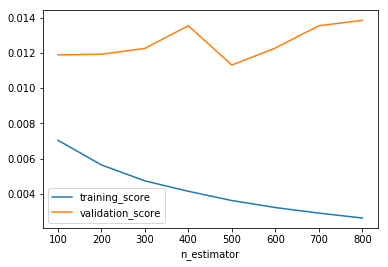

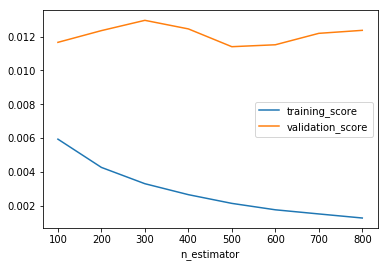

In [41]:
fig, ax = plt.subplots()
ax = temp_df[temp_df.max_depth==3].plot.line('n_estimator','training_score',ax =ax)
ax = temp_df[temp_df.max_depth==3].plot.line('n_estimator','validation_score',ax =ax)
plt.show()
fig, ax = plt.subplots()
ax = temp_df[temp_df.max_depth==4].plot.line('n_estimator','training_score',ax =ax)
ax = temp_df[temp_df.max_depth==4].plot.line('n_estimator','validation_score',ax =ax)
plt.show()
#,'validation_score')

##### Kaggle score remained unchanged, this proves that our logic of test score calculation fails and there must be some value prediction which is huge which brings the average error value up


##### Next Steps:
* re run the grid search and note training score, validation score and testing score. This should not only double check on test score calculation but also gives us the right hyper parameter from the training and validation perspective.
* address the runtime error during scaling or power transform. If boxcox fails attempt a log transformation at least.
* stratify fold testing to check if the training score & validation in the previous exercise still holds goods.
* hyper parameter research for XGBoost
* target variable transformation
* best of best stack approach
* team work stack approach
* XGBoost as the final assesser in best of best stack approach
* XGBoost as the final assesser in the team work starck approach
* 3 layers in stack approach: best of best candidates in the order of their accuracy feeding on input in each case.
* re-assess the dataset

##### The grid search in the kaggle resulted in the different hyper parameter for lowest validation score. Not sure why is that ? validation is through the shuffle split. isnt 3 cross validation set sufficient ?

##### Or it is a game of kfold shuffle split and stratify ?

##### It only makes sense to move on for stacked approach and other hyper parameter tuning if we sort out the cross validation consistency issue. Otherwise, we cannot have the confidence of impact of changes in stacked approaches.